## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
# se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds"
# sample_names = "preB,postB"
# outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/de_btwnCond_RNA/minPct_0_logfc0.01"
# top_de = 3
# se_f = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds" 
# outdir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones"
# top_de = 3
# sample_names = "pre,post"


se_f = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds"
p_thresh = 0.1 
outdir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones" 
top_de = 3
sample_names = "pre,post"

# Input info
# se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/SE.rds"
# sample_names = "preB,postB"
# outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00_pval0.1"


# Parallel processing
cores = 4

# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"



# Parameters
assay="RNA"
minPct = 0.00
logfcthresh = 0.1
test.use="wilcox"
latent.vars = "NULL"


In [2]:
source(utils_script)
source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")
dir.create(outdir, showWarnings = FALSE)

btwnConds_inClust_sepDonrs.outdir <- file.path(outdir, "btwnConds_inClust_sepDonrs")
dir.create(btwnConds_inClust_sepDonrs.outdir)

btwnConds_inClust.outdir <- file.path(outdir, "btwnConds_inClust")
dir.create(btwnConds_inClust.outdir, showWarnings = FALSE)

Attaching SeuratObject

Warning message in dir.create(btwnConds_inClust_sepDonrs.outdir):
“'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs' already exists”


In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "pre"  "post"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Lo

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
97805 features across 22239 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

# Stimulus specific response in each cluster 

## Stimulus specific response in each cluster, not splitting donors

In [6]:
all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()

#sample_names
cluster.ids <- sort(unique(se$seurat_clusters))
se$celltype.stim <- paste(se$seurat_clusters, se$orig.ident, sep = "_")
se$celltype <- se$seurat_clusters
Idents(se) <- "celltype.stim"

for (curr.clust in cluster.ids){
    ident.1 = paste0(curr.clust, "_", sample_names[[1]]) 
    ident.2 = paste0(curr.clust, "_", sample_names[[2]])
    try({
        print(curr.clust)
        #se.filt <- subset(se, idents = c(ident.1,ident.2))
        #curr.donor = se.filt$donor[[1]] #strsplit(c,"_")[[2]]
        curr.name <-paste0("clust_", curr.clust)
        curr.clust.outdir <- file.path(btwnConds_inClust.outdir, paste0("clust_", curr.clust))
        dir.create(curr.clust.outdir)

#         curr.sig <- find.markers.and.plot(se, ident.1, ident.2, curr.clust.outdir, curr.name=curr.clust, 
#                               min.pct=minPct, p.thresh=p_thresh)
        curr.sig <- find.markers.and.plot(se, ident.1, ident.2, curr.clust.outdir, 
                                          curr.name=curr.clust, assay="RNA", logfcthresh=logfcthresh,
                                          min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
        names.sig <- rownames(curr.sig)
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        
        all.pvals[names.sig,curr.clust] <- curr.sig$p_val_adj_BH

        curr_clust <- subset(se, seurat_clusters == curr.clust)
        avg_curr_clust <- data.frame(log1p(AverageExpression(curr_clust, verbose = FALSE)$RNA))
        avg_curr_clust$gene <- rownames(avg_curr_clust)
        p1 <- ggplot(avg_curr_clust, aes_string(paste0("X", curr.clust, "_", sample_names[[1]]), 
                                                paste0("X", curr.clust, "_", sample_names[[2]]))) + geom_point() + ggtitle(paste("Cluster", curr.clust))
        p1 <- LabelPoints(plot = p1, points = names.sig, repel = TRUE)
        plot_grid(p1)
        #write.csv(response, file=file.path(curr.clust.outdir,paste0("cluster_",c,".conditionDE.csv")))
        ggsave(file.path(curr.clust.outdir,paste0("cluster_",curr.clust,".allDonors.conditionScatter.png")))
        
        })
    }
     



[1] "0"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2691 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB   7.865996e-44  0.3622686 0.923 0.746 1.539769e-39 2.414861e-41
FLNB    2.268357e-36  0.2448797 0.683 0.381 4.440308e-32 3.481928e-34
RAPGEF1 8.366487e-36  0.2405502 0.612 0.330 1.637740e-31 8.561705e-34
RASSF2  1.240837e-31  0.2039474 0.591 0.318 2.428939e-27 9.523425e-30
FNBP1   7.237347e-31  0.2502571 0.839 0.596 1.416711e-26 4.443731e-29
KRT72   2.206183e-30  0.1445321 0.417 0.186 4.318602e-26 1.128830e-28
[1] "dim response"
[1] 307   6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB   7.865996e-44  0.3622686 0.923 0.746 1.539769e-39 2.414861e-41
FLNB    2.268357e-36  0.2448797 0.683 0.381 4

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 218 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2459 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
SYTL3   2.739574e-30  0.2722615 0.626 0.319 5.362715e-26 1.956056e-27
BIRC3   2.787779e-28  0.2103408 0.439 0.188 5.457078e-24 9.952372e-26
ABCG1   2.966562e-26  0.2610594 0.472 0.224 5.807045e-22 7.060418e-24
FNBP1   4.718362e-26  0.2933553 0.594 0.310 9.236193e-22 8.422276e-24
UBASH3A 8.231982e-26  0.1802530 0.299 0.110 1.611410e-21 1.175527e-23
GRK5    1.032500e-25  0.2650152 0.629 0.345 2.021119e-21 1.228675e-23
[1] "dim response"
[1] 714   6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
SYTL3   2.739574e-30  0.2722615 0.626 0.319 5.362715e-26 1.956056e-27
BIRC3   2.787779e-28  0.2103408 0.439 0.188 5

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 330 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "2"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_2' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2431 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TMEM141        2.116612e-27  0.1812459 0.427 0.187 4.143268e-23 6.900154e-25
CTD-2192J16.17 1.693665e-23  0.1640323 0.444 0.207 3.315349e-19 2.760674e-21
RP11-216L13.17 4.026645e-23  0.1734497 0.480 0.236 7.882158e-19 4.375621e-21
PLK3           4.907062e-22  0.1178678 0.378 0.168 9.605573e-18 3.999255e-20
AP3D1          6.812901e-21  0.1340781 0.375 0.171 1.333625e-16 4.442012e-19
CCT3           1.467880e-20  0.1319138 0.370 0.169 2.873375e-16 7.975480e-19
[1] "dim response"
[1] 326   6
[1] "response plots"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TMEM141        2.116612e-27  0.1812459 0.427 0.187 4.143268

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 116 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "3"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_3' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2199 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
LEF1  1.561426e-58 -0.3700602 0.256 0.696 3.056491e-54 1.224158e-55
TLE4  1.006469e-49 -0.2264988 0.182 0.538 1.970162e-45 3.945357e-47
MLLT3 3.728236e-49 -0.2990018 0.199 0.557 7.298022e-45 9.743123e-47
SCML4 8.101153e-49 -0.2430941 0.211 0.586 1.585801e-44 1.587826e-46
JUN   5.234439e-47 -0.2287136 0.163 0.497 1.024641e-42 8.207601e-45
FOSB  1.183842e-46 -0.2140562 0.191 0.543 2.317371e-42 1.546887e-44
[1] "dim response"
[1] 784   6
[1] "response plots"
             p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
LEF1  1.561426e-58 -0.3700602 0.256 0.696 3.056491e-54 1.224158e-55
TLE4  1.006469e-49 -0.2264988 0.182 0.538 1.970162e-45 3.945357

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 758 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "4"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_4' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2016 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MIDN    7.943361e-21  0.1437037 0.470 0.224 1.554913e-16 2.136764e-18
NR1H2   3.844512e-20  0.1844735 0.613 0.335 7.525633e-16 5.170869e-18
STAP2   1.423949e-19  0.1479712 0.555 0.285 2.787381e-15 1.276808e-17
ATXN2L  1.123954e-18  0.1121943 0.355 0.155 2.200140e-14 7.558589e-17
SERTAD1 9.229822e-18  0.1131651 0.372 0.167 1.806738e-13 4.965644e-16
SWSAP1  1.207932e-17  0.1379044 0.485 0.247 2.364527e-13 5.415561e-16
[1] "dim response"
[1] 269   6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MIDN    7.943361e-21  0.1437037 0.470 0.224 1.554913e-16 2.136764e-18
NR1H2   3.844512e-20  0.1844735 0.613 0.335 7

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 69 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "5"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_5' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1741 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT72  7.771819e-21  0.1752561 0.291 0.078 1.521334e-16 6.567187e-18
CCDC57 3.519209e-16  0.3090953 0.590 0.298 6.888852e-12 1.486866e-13
MAP2K2 2.963964e-14  0.1838229 0.402 0.166 5.801959e-10 8.348498e-12
SMAP2  3.647033e-12  0.2742077 0.675 0.403 7.139068e-08 6.969874e-10
SYTL3  4.124186e-12  0.2846384 0.620 0.360 8.073094e-08 6.969874e-10
ALOXE3 2.908680e-11  0.1579195 0.385 0.173 5.693742e-07 4.096391e-09
[1] "dim response"
[1] 845   6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT72  7.771819e-21  0.1752561 0.291 0.078 1.521334e-16 6.567187e-18
CCDC57 3.519209e-16  0.3090953 0.590 0.298 6.888852e-1

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 506 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "6"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_6' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1586 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TCTA   9.534575e-19  0.1863300 0.472 0.216 1.866393e-14 2.869907e-16
PRKACA 2.025104e-17  0.1485397 0.451 0.203 3.964141e-13 3.047781e-15
SEPT2  8.367278e-17  0.1480352 0.428 0.193 1.637895e-12 8.395169e-15
AP2A1  2.824170e-15  0.1479574 0.497 0.244 5.528312e-11 1.824340e-13
HDLBP  3.098979e-15  0.1537803 0.486 0.241 6.066251e-11 1.824340e-13
RHOA   3.636558e-15  0.1507759 0.449 0.220 7.118562e-11 1.824340e-13
[1] "dim response"
[1] 301   6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TCTA   9.534575e-19  0.1863300 0.472 0.216 1.866393e-14 2.869907e-16
PRKACA 2.025104e-17  0.1485397 0.451 0.203 3.964141e-1

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 106 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "7"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_7' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1476 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
SLC9A1 2.986822e-13  0.1389370 0.313 0.138 5.846703e-09 1.030453e-10
RAB40C 2.075228e-12  0.1485442 0.365 0.183 4.062259e-08 3.579769e-10
CDCA4  3.618253e-11  0.1415111 0.338 0.171 7.082731e-07 2.679964e-09
PHLDB3 3.662601e-11  0.1084066 0.271 0.124 7.169541e-07 2.679964e-09
RAVER1 4.070861e-11  0.1113632 0.234 0.100 7.968710e-07 2.679964e-09
GMFG   4.919126e-11  0.1413559 0.367 0.193 9.629189e-07 2.679964e-09
[1] "dim response"
[1] 345   6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
SLC9A1 2.986822e-13  0.1389370 0.313 0.138 5.846703e-09 1.030453e-10
RAB40C 2.075228e-12  0.1485442 0.365 0.183 4.062259e-0

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 104 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "8"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_8' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1458 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB    3.059161e-36  0.4540786 0.940 0.790 5.988308e-32 9.208074e-34
SNX9     8.666889e-31  0.3613397 0.918 0.671 1.696544e-26 1.304367e-28
TOGARAM2 3.948680e-19  0.1847094 0.561 0.276 7.729541e-15 3.961842e-17
NCR2     7.625715e-18  0.1486083 0.357 0.145 1.492734e-13 5.738351e-16
FLNB     5.106173e-17  0.2362530 0.744 0.497 9.995335e-13 3.073916e-15
ZC3H18   2.255825e-16  0.1693976 0.428 0.208 4.415778e-12 1.131672e-14
[1] "dim response"
[1] 301   6
[1] "response plots"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB    3.059161e-36  0.4540786 0.940 0.790 5.988308e-32 9.208074e-34
SNX9     8.666889e-31  0.3613397 0.9

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 233 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "9"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_9' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1435 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                     p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
STK19         5.981763e-17  0.1199931 0.325 0.120 1.170930e-12 1.572657e-14
DXO           8.127426e-17  0.1194080 0.320 0.118 1.590944e-12 1.572657e-14
CTD-2583A14.9 1.582881e-13  0.1044441 0.271 0.104 3.098489e-09 1.768462e-11
TRPM2         2.481323e-13  0.1192358 0.206 0.069 4.857190e-09 1.768462e-11
YWHAE         2.727871e-13  0.1192306 0.280 0.111 5.339808e-09 1.768462e-11
CYB5D2        2.741802e-13  0.1402726 0.421 0.202 5.367078e-09 1.768462e-11
[1] "dim response"
[1] 387   6
[1] "response plots"
                     p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
STK19         5.981763e-17  0.1199931 0.325 0.120 1.170930e-12 1.57

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 113 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "10"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_10' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 916 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
H1FOO  1.637406e-09  0.1026529 0.090 0.006 3.205223e-05 6.305652e-06
DERL3  2.975458e-08  0.2500230 0.239 0.059 5.824460e-04 5.729245e-05
BAIAP3 2.621797e-07  0.1818361 0.224 0.058 5.132168e-03 2.541694e-04
HHIPL1 2.640035e-07  0.1077079 0.090 0.009 5.167869e-03 2.541694e-04
ARG1   6.632942e-07  0.1340956 0.104 0.014 1.298398e-02 5.108692e-04
SAMM50 1.071737e-06  0.1468461 0.209 0.054 2.097925e-02 6.878766e-04
[1] "dim response"
[1] 3851    6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
H1FOO  1.637406e-09  0.1026529 0.090 0.006 3.205223e-05 6.305652e-06
DERL3  2.975458e-08  0.2500230 0.239 0.059 5.824460e-

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 645 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "11"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_11' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 784 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
PIP5K1C 6.054968e-10  0.1378257 0.253 0.085 1.185260e-05 4.111323e-07
SLCO4A1 3.505940e-09  0.1514642 0.351 0.154 6.862878e-05 1.134963e-06
YWHAB   5.014565e-09  0.1415910 0.347 0.152 9.816012e-05 1.134963e-06
MBD3L1  1.639985e-08  0.1436455 0.457 0.231 3.210271e-04 2.580059e-06
STAT5B  1.899896e-08  0.1524778 0.468 0.245 3.719047e-04 2.580059e-06
ZNF558  2.438183e-08  0.1453219 0.453 0.231 4.772744e-04 2.759211e-06
[1] "dim response"
[1] 679   6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
PIP5K1C 6.054968e-10  0.1378257 0.253 0.085 1.185260e-05 4.111323e-07
SLCO4A1 3.505940e-09  0.1514642 0.351 0.154 6.

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 331 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "12"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_12' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 354 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
AK7    3.109682e-08  0.3872775 0.559 0.220 0.0006087203 4.147248e-05
FAM65A 4.479991e-08  0.4006176 0.706 0.353 0.0008769583 4.147248e-05
MYO15B 5.087858e-08  0.3575163 0.456 0.154 0.0009959483 4.147248e-05
AP3D1  5.124805e-08  0.4285822 0.544 0.203 0.0010031805 4.147248e-05
PRCD   1.120325e-07  0.1733936 0.221 0.035 0.0021930355 7.252982e-05
CENPT  1.857637e-07  0.3212631 0.559 0.231 0.0036363253 1.002195e-04
[1] "dim response"
[1] 3237    6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
AK7    3.109682e-08  0.3872775 0.559 0.220 0.0006087203 4.147248e-05
FAM65A 4.479991e-08  0.4006176 0.706 0.353 0.00087695

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 1114 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "13"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_13' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 313 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
SLC9A8 9.625852e-09  0.2439934 0.438 0.125 0.000188426 1.576714e-05
TCF25  3.593262e-08  0.2352726 0.457 0.149 0.000703381 2.942881e-05
ZNF696 8.991770e-08  0.1642771 0.190 0.019 0.001760139 4.909506e-05
PAQR4  2.301435e-07  0.1540377 0.171 0.014 0.004505058 9.306661e-05
MAD1L1 3.166855e-07  0.3717238 0.895 0.596 0.006199119 9.306661e-05
PKMYT1 3.409033e-07  0.1550705 0.248 0.048 0.006673183 9.306661e-05
[1] "dim response"
[1] 1638    6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
SLC9A8 9.625852e-09  0.2439934 0.438 0.125 0.000188426 1.576714e-05
TCF25  3.593262e-08  0.2352726 0.457 0.149 0.000703381 2.94288

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 779 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "14"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_14' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 274 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
LMX1B   1.708534e-10  0.3277797 0.566 0.140 3.344454e-06 4.259374e-07
PTDSS2  6.642514e-09  0.3044741 0.623 0.208 1.300272e-04 8.279894e-06
RPL17   1.077887e-07  0.2035354 0.358 0.077 2.109963e-03 8.785766e-05
FBXO17  1.785588e-07  0.1429940 0.283 0.045 3.495288e-03 8.785766e-05
TRIM38  1.865692e-07  0.2288860 0.434 0.118 3.652092e-03 8.785766e-05
ANKRD60 2.114504e-07  0.1239930 0.226 0.027 4.139143e-03 8.785766e-05
[1] "dim response"
[1] 2493    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
LMX1B   1.708534e-10  0.3277797 0.566 0.140 3.344454e-06 4.259374e-07
PTDSS2  6.642514e-09  0.3044741 0.623 0.208 

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 1051 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


[1] "15"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust/clust_15' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 106 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
FCHSD1   1.251798e-07  0.2867006 0.500 0.044 0.002450394 0.0006496831
PLPP5    1.797809e-06  0.3000076 0.562 0.078 0.035192119 0.0046653154
ARHGEF17 3.900757e-06  0.4454971 0.688 0.167 0.076357325 0.0067483102
BEND4    6.802558e-06  0.3781456 0.375 0.033 0.133160071 0.0083787408
ACTR3C   8.072005e-06  0.1482622 0.375 0.033 0.158009491 0.0083787408
SEPN1    1.132222e-05  0.1348671 0.375 0.033 0.221632492 0.0097937218
[1] "dim response"
[1] 5190    6
[1] "response plots"
                p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
FCHSD1   1.251798e-07  0.2867006 0.500 0.044 0.002450394 0.0006496831
PLPP5    1.797809e-06  0.3000076 0.562 0.078

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image

Warning message:
"ggrepel: 261 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


## DE sig summarize

In [7]:
all.names.sig

[1] "ITPKB"          "FLNB"           "RAPGEF1"        "SYTL3"         
 [5] "BIRC3"          "ABCG1"          "TMEM141"        "CTD-2192J16.17"
 [9] "RP11-216L13.17" "LEF1"           "TLE4"           "MLLT3"         
[13] "MIDN"           "NR1H2"          "STAP2"          "KRT72"         
[17] "CCDC57"         "MAP2K2"         "TCTA"           "PRKACA"        
[21] "SEPT2"          "SLC9A1"         "RAB40C"         "CDCA4"         
[25] "ITPKB"          "SNX9"           "TOGARAM2"       "STK19"         
[29] "DXO"            "CTD-2583A14.9"  "H1FOO"          "DERL3"         
[33] "BAIAP3"         "PIP5K1C"        "SLCO4A1"        "YWHAB"         
[37] "AK7"            "FAM65A"         "MYO15B"         "SLC9A8"        
[41] "TCF25"          "ZNF696"         "LMX1B"          "PTDSS2"        
[45] "RPL17"          "FCHSD1"         "PLPP5"          "ARHGEF17"

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



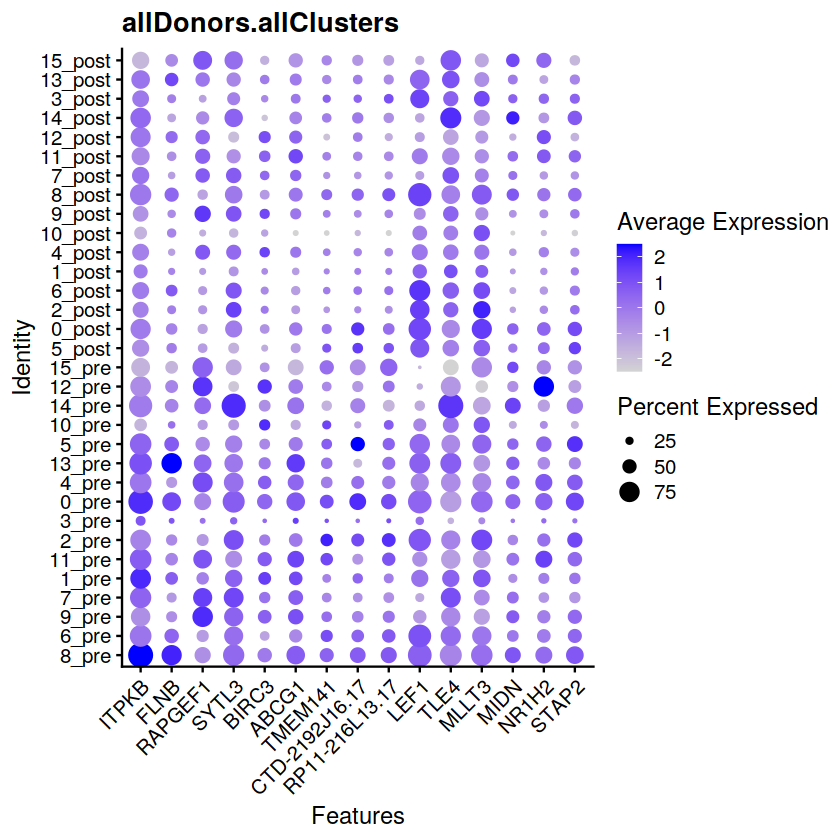

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



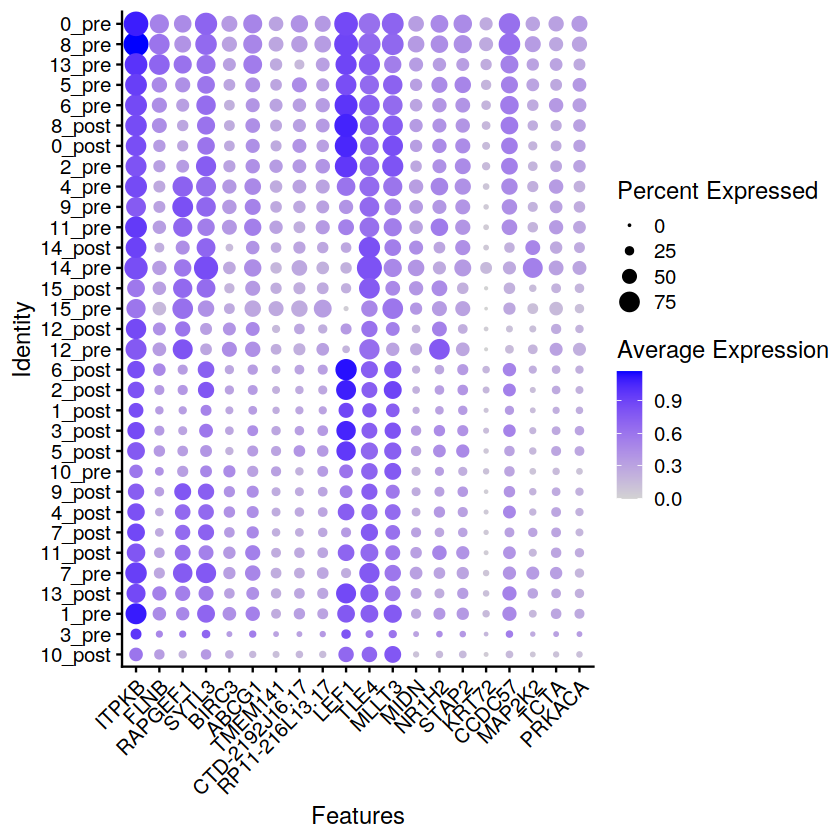

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



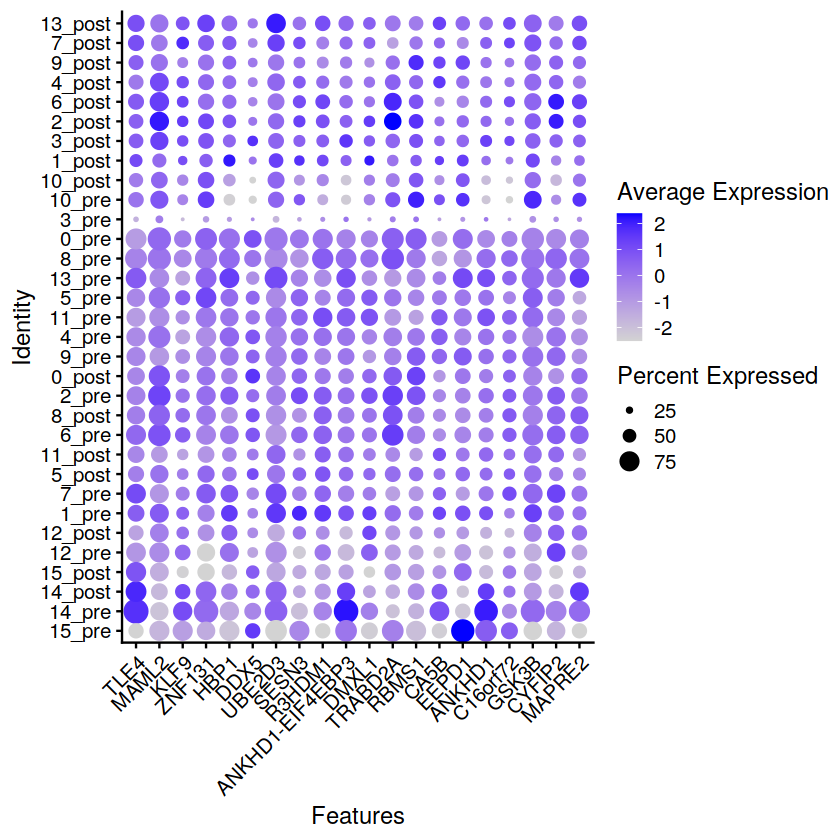

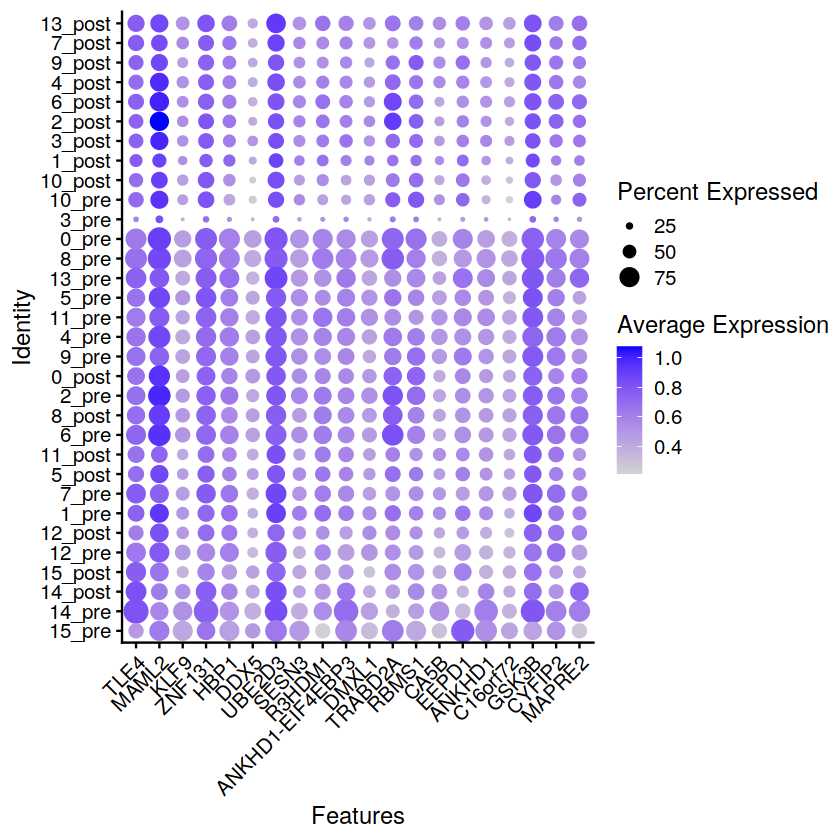

In [8]:
### a) top 3 significant results from each comparison

all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, btwnConds_inClust.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=FALSE,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.top3de.png"))
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.top3de.pdf"))

## b) averaged top p-values (only average ones that were DE)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot


## Each donor separately

In [9]:
se$condition.name <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
se$condition.clust <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters") ] , 1 , paste , collapse = "_" ))

In [10]:
# get clust and donor information
source(utils_script)
clust.ids <- levels(se$seurat_clusters)
don.ids <- levels(se$donor)
#cols <- c("seurat_clusters", "donor")
curr.ids <- levels(as.factor(apply(se[[]][ , c( "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" )))
# Setup Idents to include the condition, clusters and donor
Idents(se) <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
se$curr.id = Idents(se)

# setup output
# all.pvals is gene-by-comparison df of the pvalue results
all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()

# Loop through clusters and donors and compare between conditions
for (cl in clust.ids){
    if (cl == "None"){
        next
    }
    for (d in don.ids){
        if (d == "None"){
            print('Skipping None')
            next
        }
        c <- paste0(cl, "_", d)
        cl.names.sig = c()
        
        try({
            print("c")
            print(c)
            id1 <- paste(sample_names[[1]], c, sep="_")
            id2 <- paste(sample_names[[2]], c, sep="_")         
            curr.name <- c
            curr.name <- paste(c, sample_names[[1]], sample_names[[2]], sep='_')
            curr.clust.donor.outdir <- file.path(btwnConds_inClust_sepDonrs.outdir,
                                                 paste0("clust_", cl, "donor_", d))
            dir.create(curr.clust.donor.outdir)

            curr.sig <- find.markers.and.plot(se, id1, id2, curr.clust.donor.outdir, 
                                              curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                              min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
            if (length(names(curr.sig)) > 0){
                print("adding sig vals to all pvals")
                names.sig <- rownames(curr.sig)
                all.names.sig <- c(all.names.sig, head(names.sig, top_de))
                all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
            }else{
                print("no sig variables found")
            }
        })
    }
}

[1] "c"
[1] "0_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_0donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 96 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4669    6
[1] "adding sig vals to all pvals"
[1] "c"
[1] "0_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_0donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1903 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB   4.273353e-41  0.3961630 0.944 0.755 8.365089e-37 1.517040e-38
FLNB    3.072906e-30  0.2478429 0.703 0.372 6.015214e-26 5.454409e-28
RAPGEF1 2.237401e-27  0.2429896 0.631 0.336 4.379713e-23 2.647591e-25
BATF    2.125848e-26  0.1693690 0.360 0.133 4.161348e-22 1.886690e-24
KRT72   3.958617e-26  0.1676726 0.432 0.177 7.748994e-22 2.810618e-24
ZC3H12A 3.696246e-25  0.1827166 0.481 0.215 7.235401e-21 2.186945e-23
[1] "dim response"
[1] 355   6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB   4.273353e-41  0.3961630 0.944 0.755 8.365089e-37 1.517040e-38
FLNB    3.072906e-30  0.2478429 0.703 0.372 6

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "1_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_1donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 238 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
CARD8   1.392757e-07  0.3249964 0.299 0.047 0.002726322 0.0003122194
CFAP99  1.552558e-07  0.2585382 0.269 0.035 0.003039132 0.0003122194
TUBA1B  1.202942e-06  0.3682410 0.418 0.117 0.023547599 0.0012873972
CCDC167 1.560320e-06  0.2598332 0.269 0.047 0.030543261 0.0012873972
PBX3    1.703006e-06  0.3892818 0.373 0.099 0.033336339 0.0012873972
NFKBID  2.136804e-06  0.4056546 0.328 0.082 0.041827931 0.0012873972
[1] "dim response"
[1] 4022    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
CARD8   1.392757e-07  0.3249964 0.299 0.047 0.002726322 0.0003122194
CFAP99  1.552558e-07  0.2585382 0.269 0.035 0.0030391

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "1_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_1donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1384 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
SYTL3  3.522934e-26  0.3525230 0.670 0.325 6.896144e-22 3.262237e-23
ITPKB  1.409432e-25  0.4933128 0.810 0.514 2.758964e-21 6.525672e-23
FNBP1  1.295584e-21  0.3478659 0.643 0.328 2.536105e-17 3.999035e-19
RGS1   2.366877e-21  0.2054778 0.233 0.055 4.633162e-17 5.479321e-19
ABCG1  3.763999e-20  0.2963456 0.514 0.241 7.368029e-16 6.970927e-18
TGFBR3 7.309526e-20  0.3136604 0.581 0.292 1.430840e-15 9.993826e-18
[1] "dim response"
[1] 926   6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
SYTL3  3.522934e-26  0.3525230 0.670 0.325 6.896144e-22 3.262237e-23
ITPKB  1.409432e-25  0.4933128 0.810 0.514 2.758964e-2

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "2_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_2donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1806 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TMEM141        6.600979e-22  0.1903946 0.432 0.189 1.292142e-17 2.785613e-19
AP3D1          2.233975e-20  0.1497062 0.366 0.147 4.373006e-16 4.713688e-18
CTD-2192J16.17 3.738663e-20  0.1728178 0.437 0.192 7.318434e-16 5.259053e-18
PLK3           9.795278e-19  0.1249408 0.380 0.161 1.917426e-14 1.033402e-16
RP11-216L13.17 2.941021e-18  0.1778844 0.487 0.238 5.757049e-14 2.482222e-16
CTC-435M10.3   5.737463e-18  0.1887786 0.591 0.315 1.123108e-13 4.035349e-16
[1] "dim response"
[1] 422   6
[1] "response plots"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TMEM141        6.600979e-22  0.1903946 0.432 0.189 1.292142

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "2_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_2donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 105 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
SKIV2L   4.149904e-06  0.2864778 0.458 0.053 0.08123438  0.008917829
EFCAB14  4.955900e-06  0.2697946 0.500 0.070 0.09701173  0.008917829
C12orf57 6.762106e-06  0.3354305 0.562 0.105 0.13236823  0.008917829
NELFE    9.058344e-06  0.2823043 0.438 0.053 0.17731708  0.008917829
DHRS12   1.268967e-05  0.3999815 0.688 0.193 0.24840030  0.008917829
LUC7L2   1.502764e-05  0.5510597 0.854 0.386 0.29416600  0.008917829
[1] "dim response"
[1] 4154    6
[1] "response plots"
                p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
SKIV2L   4.149904e-06  0.2864778 0.458 0.053 0.08123438  0.008917829
EFCAB14  4.955900e-06  0.2697946 0.500 0.070 0.097011

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "3_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_3donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 65 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7370    6
[1] "adding sig vals to all pvals"
[1] "c"
[1] "3_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_3donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 568 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
GDPD1   1.679450e-07  0.3398209 0.311 0.089 0.003287524 0.0004835137
GRIN1   5.998061e-07  0.1506516 0.148 0.022 0.011741205 0.0008161973
TUSC2   8.505008e-07  0.2483686 0.311 0.091 0.016648553 0.0008161973
SNX9    8.808533e-06  0.5474059 0.803 0.533 0.172427028 0.0062009815
B4GALT6 1.076933e-05  0.1365111 0.164 0.034 0.210809679 0.0062009815
ZDHHC3  1.360315e-05  0.1889596 0.213 0.057 0.266281717 0.0065272462
[1] "dim response"
[1] 2879    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
GDPD1   1.679450e-07  0.3398209 0.311 0.089 0.003287524 0.0004835137
GRIN1   5.998061e-07  0.1506516 0.148 0.022 0.0117412

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "4_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_4donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1173 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
STAP2   1.562613e-17  0.2160780 0.578 0.266 3.058815e-13 6.193454e-15
ZSCAN5A 2.487331e-17  0.1882239 0.410 0.158 4.868950e-13 6.193454e-15
NCAPH2  3.208428e-16  0.1286988 0.349 0.122 6.280498e-12 5.325991e-14
LMF2    6.635680e-16  0.1222404 0.342 0.119 1.298934e-11 8.235850e-14
ZNF83   8.268926e-16  0.1385630 0.467 0.198 1.618642e-11 8.235850e-14
MIDN    1.863386e-15  0.1726049 0.456 0.198 3.647578e-11 1.546610e-13
[1] "dim response"
[1] 498   6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
STAP2   1.562613e-17  0.2160780 0.578 0.266 3.058815e-13 6.193454e-15
ZSCAN5A 2.487331e-17  0.1882239 0.410 0.158 4

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "4_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_4donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 238 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
BCL3   3.651329e-10  0.4095417 0.613 0.182 7.147476e-06 6.864498e-07
ZC3H18 3.943567e-08  0.3023038 0.453 0.121 7.719532e-04 3.706953e-05
HMHA1  3.750542e-07  0.3484346 0.764 0.356 7.341687e-03 1.992583e-04
ITPKB  5.388724e-07  0.4883958 0.943 0.727 1.054843e-02 1.992583e-04
BCL11B 5.656327e-07  0.4202542 0.981 0.758 1.107226e-02 1.992583e-04
TGFBR3 7.017501e-07  0.4193840 0.858 0.515 1.373676e-02 1.992583e-04
[1] "dim response"
[1] 1880    6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
BCL3   3.651329e-10  0.4095417 0.613 0.182 7.147476e-06 6.864498e-07
ZC3H18 3.943567e-08  0.3023038 0.453 0.121 7.719532e-

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "5_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_5donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 50 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
TGIF2 1.139571e-05 -0.7805533  0.05   0.6 0.2230711   0.09717125
[1] "dim response"
[1] 8527    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
TGIF2   1.139571e-05 -0.7805533 0.050   0.6 0.2230711   0.09717125
OSTC    4.556232e-04 -0.3293009 0.000   0.3 1.0000000   0.57826602
VWDE    4.556232e-04 -0.4375341 0.000   0.3 1.0000000   0.57826602
SLITRK5 4.556232e-04 -0.5305894 0.000   0.3 1.0000000   0.57826602
TRIM36  6.172514e-04 -0.4236044 0.025   0.4 1.0000000   0.57826602
TM7SF2  8.261615e-04 -0.4912860 0.075   0.5 1.0000000   0.57826602
[1] "TGIF2"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "5_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_5donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1213 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT72    6.040458e-29  0.2444806 0.373 0.068 1.182420e-24 7.151902e-26
CCDC57   5.801586e-21  0.3746827 0.687 0.278 1.135660e-16 3.434539e-18
SECTM1   9.336136e-17  0.1111170 0.187 0.030 1.827549e-12 3.684662e-14
MAP2K2   1.847825e-16  0.2194522 0.500 0.175 3.617117e-12 5.469562e-14
SYTL3    8.656884e-16  0.3541805 0.717 0.345 1.694585e-11 2.049950e-13
TNFRSF1B 6.688644e-15  0.2615086 0.524 0.206 1.309302e-10 1.319892e-12
[1] "dim response"
[1] 1184    6
[1] "response plots"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT72    6.040458e-29  0.2444806 0.373 0.068 1.182420e-24 7.151902e-26
CCDC57   5.801586e-21  0.3746827 0

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "6_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_6donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1191 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
OSBPL2 8.146560e-18  0.1748235 0.323 0.105 1.594689e-13 3.397115e-15
SEPT2  3.861158e-16  0.1601014 0.428 0.168 7.558216e-12 8.050514e-14
AP2A1  9.097888e-16  0.1612778 0.515 0.221 1.780912e-11 1.264606e-13
TCTA   1.747052e-15  0.1627509 0.466 0.197 3.419855e-11 1.821302e-13
IL4I1  3.259690e-15  0.1307354 0.318 0.110 6.380843e-11 2.718581e-13
RFXANK 4.010502e-15  0.1280338 0.273 0.087 7.850558e-11 2.787299e-13
[1] "dim response"
[1] 417   6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
OSBPL2 8.146560e-18  0.1748235 0.323 0.105 1.594689e-13 3.397115e-15
SEPT2  3.861158e-16  0.1601014 0.428 0.168 7.558216e-1

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "6_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_6donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 59 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
ABHD8   5.654144e-06  0.5796588 0.774 0.143 0.1106799   0.03284492
MRPL34  3.471722e-05  0.4820218 0.613 0.071 0.6795897   0.06997911
C8orf37 3.614001e-05  0.4443123 0.742 0.143 0.7074407   0.06997911
[1] "dim response"
[1] 5809    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
ABHD8   5.654144e-06  0.5796588 0.774 0.143 0.1106799   0.03284492
MRPL34  3.471722e-05  0.4820218 0.613 0.071 0.6795897   0.06997911
C8orf37 3.614001e-05  0.4443123 0.742 0.143 0.7074407   0.06997911
WIPI1   1.176958e-04  0.4621794 0.548 0.071 1.0000000   0.15671791
PQLC1   1.376902e-04  0.5095042 0.613 0.107 1.0000000   0.15671791
WWC3 

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "7_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_7donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 661 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                     p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TCF3          7.358072e-12  0.1696526 0.285 0.075 1.440343e-07 7.372788e-09
CNOT3         1.150767e-10  0.2115735 0.570 0.259 2.252626e-06 4.740139e-08
PAK2          1.419203e-10  0.1227857 0.308 0.095 2.778090e-06 4.740139e-08
CARM1         1.952634e-10  0.1710791 0.437 0.178 3.822280e-06 4.891347e-08
SYNGR4        2.808445e-10  0.1981167 0.371 0.142 5.497532e-06 5.628124e-08
RP5-994D16.12 3.916779e-10  0.1367710 0.325 0.109 7.667094e-06 6.541020e-08
[1] "dim response"
[1] 1002    6
[1] "response plots"
                     p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TCF3          7.358072e-12  0.1696526 0.285 0.075 1.440343e-07 7.3

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "7_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_7donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 270 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
FBXO16 5.811119e-06  0.3491413 0.679 0.386 0.1137527  0.006870739
ASTL   6.777567e-06  0.3179858 0.268 0.070 0.1326709  0.006870739
PLB1   1.027748e-05  0.3462510 0.500 0.228 0.2011816  0.006870739
SMAP2  1.138718e-05  0.3777624 0.536 0.285 0.2229041  0.006870739
WDR48  1.670514e-05  0.2319208 0.321 0.095 0.3270031  0.006870739
FCER2  1.788326e-05  0.2161780 0.205 0.038 0.3500648  0.006870739
[1] "dim response"
[1] 2563    6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
FBXO16 5.811119e-06  0.3491413 0.679 0.386 0.1137527  0.006870739
ASTL   6.777567e-06  0.3179858 0.268 0.070 0.1326709  0.006870739
PLB1   1.02774

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "8_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_8donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 51 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 6600    6
[1] "adding sig vals to all pvals"
[1] "c"
[1] "8_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_8donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1157 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB    2.700011e-34  0.4877636 0.953 0.786 5.285271e-30 1.069204e-31
SNX9     2.573572e-24  0.3548215 0.927 0.650 5.037768e-20 5.095673e-22
TOGARAM2 1.036882e-18  0.1925245 0.564 0.242 2.029696e-14 1.368684e-16
ZC3H18   9.675317e-17  0.1908548 0.427 0.172 1.893943e-12 9.578564e-15
NFATC1   7.651618e-16  0.2684887 0.757 0.444 1.497804e-11 6.060082e-14
POLR1A   4.820383e-15  0.2030482 0.745 0.441 9.435899e-11 3.181453e-13
[1] "dim response"
[1] 396   6
[1] "response plots"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB    2.700011e-34  0.4877636 0.953 0.786 5.285271e-30 1.069204e-31
SNX9     2.573572e-24  0.3548215 0.9

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "9_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_9donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 896 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
FN3KRP         2.116237e-14  0.1179899 0.196 0.035 4.142533e-10 1.250696e-11
MRPS18B        3.421086e-13  0.2113709 0.482 0.202 6.696776e-09 1.010931e-10
C19orf68       1.111128e-12  0.1936371 0.328 0.119 2.175032e-08 2.188921e-10
LIG1           3.000523e-12  0.1758435 0.313 0.112 5.873523e-08 3.741779e-10
TRIM26         3.165634e-12  0.1498625 0.383 0.151 6.196728e-08 3.741779e-10
HNRNPUL2-BSCL2 9.469821e-12  0.2559065 0.651 0.369 1.853718e-07 9.327774e-10
[1] "dim response"
[1] 591   6
[1] "response plots"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
FN3KRP         2.116237e-14  0.1179899 0.196 0.035 4.142533e

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "9_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_9donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 102 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
PLCD3   3.898696e-05  0.2620386 0.267 0.000 0.7631697   0.05745492
SPRYD3  4.602550e-05  0.2994078 0.467 0.088 0.9009491   0.05745492
IL12RB2 6.179049e-05  0.3420296 0.378 0.053 1.0000000   0.05745492
BTBD11  7.310323e-05  0.5898465 0.800 0.404 1.0000000   0.05745492
EGR3    7.962325e-05  0.2935438 0.333 0.035 1.0000000   0.05745492
TOMM22  8.936659e-05  0.1983130 0.244 0.000 1.0000000   0.05745492
[1] "dim response"
[1] 4243    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
PLCD3   3.898696e-05  0.2620386 0.267 0.000 0.7631697   0.05745492
SPRYD3  4.602550e-05  0.2994078 0.467 0.088 0.9009491   0.05745492
IL12

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "10_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_10donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 59 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7422    6
[1] "adding sig vals to all pvals"
[1] "c"
[1] "10_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_10donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 463 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                   p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TMEM208     2.929361e-10  0.3873045 0.273 0.023 5.734224e-06 1.939237e-06
FKBPL       6.764897e-09  0.2506532 0.227 0.018 1.324229e-04 2.239181e-05
AC040160.13 1.513390e-08  0.3802543 0.273 0.029 2.962461e-04 3.339547e-05
UBE4A       8.520765e-08  0.4514887 0.364 0.059 1.667940e-03 1.410187e-04
SCAMP3      1.578425e-07  0.2276812 0.227 0.023 3.089768e-03 2.089835e-04
ZBTB8B      4.243905e-07  0.1229466 0.091 0.002 8.307445e-03 3.319707e-04
[1] "dim response"
[1] 6620    6
[1] "response plots"
                   p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TMEM208     2.929361e-10  0.3873045 0.273 0.023 5.734224e-06 1.939237e-06
FKBPL   

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "11_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_11donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 211 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
MANF    6.411992e-07  0.2714581 0.351 0.062 0.01255147  0.001645317
DPAGT1  2.525167e-06  0.2685041 0.430 0.124 0.04943014  0.003239789
C2CD2L  6.728337e-06  0.2554585 0.456 0.155 0.13170719  0.005754971
DAP3    2.067225e-05  0.1983254 0.263 0.041 0.40465920  0.012050985
SLC26A2 2.348204e-05  0.2513293 0.439 0.155 0.45966100  0.012050985
YY1AP1  3.571076e-05  0.1773342 0.254 0.041 0.69903815  0.014426612
[1] "dim response"
[1] 2566    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
MANF    6.411992e-07  0.2714581 0.351 0.062 0.01255147  0.001645317
DPAGT1  2.525167e-06  0.2685041 0.430 0.124 0.04943014  0.0032

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "11_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_11donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 195 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
ITPKB  2.573866e-06  0.4927483 0.923 0.780 0.05038343  0.005110270
BCL11B 4.116206e-06  0.5271817 0.904 0.703 0.08057473  0.005110270
SNX9   6.359097e-06  0.3900272 0.865 0.626 0.12447932  0.005263212
FAM76B 2.118400e-05  0.3686039 0.808 0.484 0.41467683  0.009153413
SCD5   2.165724e-05 -0.1900655 0.019 0.209 0.42394043  0.009153413
RSPO2  2.211860e-05 -0.2338202 0.019 0.209 0.43297153  0.009153413
[1] "dim response"
[1] 2483    6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
ITPKB  2.573866e-06  0.4927483 0.923 0.780 0.05038343  0.005110270
BCL11B 4.116206e-06  0.5271817 0.904 0.703 0.08057473  0.005110270
SNX9

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "12_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_12donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 106 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                    p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
FAM65A       1.182830e-07  0.5823152 0.717 0.200 0.002315389 0.0004697016
ZSCAN31      1.189727e-05  0.3240867 0.435 0.067 0.232888978 0.0236220213
RP11-463C8.4 2.055534e-05  0.4883690 0.696 0.233 0.402370817 0.0272084208
ZNF200       6.113081e-05  0.2187390 0.283 0.017 1.000000000 0.0606876135
U2SURP       1.010641e-04  0.3797345 0.413 0.083 1.000000000 0.0702325498
AK7          1.061182e-04  0.4124500 0.630 0.233 1.000000000 0.0702325498
[1] "dim response"
[1] 3971    6
[1] "response plots"
                    p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
FAM65A       1.182830e-07  0.5823152 0.717 0.200 0.002315389 0.0004697016
ZSCAN31 

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "12_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_12donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 109 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
FAM71E1 9.131525e-17  0.4731927 0.778  0.01 1.787496e-12 3.162247e-13
EMC10   9.131525e-17  0.4731927 0.778  0.01 1.787496e-12 3.162247e-13
RPP21   1.265201e-12  0.4108409 0.667  0.02 2.476631e-08 2.920927e-09
ZNF549  1.553007e-11  0.3516227 0.444  0.00 3.040012e-07 2.689032e-08
BRAT1   6.392055e-11  0.3871735 0.778  0.05 1.251245e-06 8.854275e-08
TMED8   2.584440e-09  0.5478624 0.778  0.07 5.059042e-05 2.983306e-06
[1] "dim response"
[1] 6926    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
FAM71E1 9.131525e-17  0.4731927 0.778  0.01 1.787496e-12 3.162247e-13
EMC10   9.131525e-17  0.4731927 0.778  0.01 

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "13_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_13donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 82 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                 p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
NLK       1.147024e-05  0.5482010 0.667 0.163 0.2245299   0.02952219
ARV1      1.506254e-05  0.6145585 0.576 0.122 0.2948491   0.02952219
THAP7     1.755184e-05  0.2901512 0.333 0.000 0.3435772   0.02952219
TPST2     3.700540e-05  0.4087766 0.455 0.061 0.7243808   0.03997702
TSSC1     4.226572e-05  0.3910491 0.606 0.122 0.8273515   0.03997702
KRTAP10-4 4.753511e-05  0.3236764 0.303 0.000 0.9304997   0.03997702
[1] "dim response"
[1] 5046    6
[1] "response plots"
                 p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
NLK       1.147024e-05  0.5482010 0.667 0.163 0.2245299   0.02952219
ARV1      1.506254e-05  0.6145585 0.576 0.122 0.294849

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "13_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_13donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 138 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                    p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
HIPK2        3.836415e-06  0.5417415 0.770 0.325 0.07509782  0.009612297
SLC9A8       5.781833e-06  0.3185675 0.492 0.117 0.11317938  0.009612297
POGZ         1.562669e-05  0.2015720 0.328 0.039 0.30589238  0.011835579
PLEKHG5      1.822918e-05  0.2518433 0.311 0.039 0.35683618  0.011835579
RP5-900K19.2 1.977966e-05  0.3735157 0.689 0.273 0.38718680  0.011835579
SENP5        2.284637e-05  0.2326936 0.377 0.065 0.44721777  0.011835579
[1] "dim response"
[1] 3325    6
[1] "response plots"
                    p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
HIPK2        3.836415e-06  0.5417415 0.770 0.325 0.07509782  0.009612297
SLC9A8       5.78

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "14_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_14donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 22 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7134    6
[1] "adding sig vals to all pvals"
[1] "c"
[1] "14_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_14donor_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 77 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
CMIP    4.054566e-06  0.8366926 0.962 0.608 0.07936812   0.01824555
ANKRD60 9.823974e-06  0.2324074 0.346 0.000 0.19230429   0.02210394
TRERF1  3.225780e-05  0.5645000 0.808 0.353 0.63144645   0.04838670
RCAN3   5.133243e-05  0.2564349 0.538 0.098 1.00000000   0.05614181
RRM2B   6.237979e-05  0.4808620 0.769 0.314 1.00000000   0.05614181
TNFSF14 9.485365e-05  0.4043449 0.615 0.157 1.00000000   0.07114024
[1] "dim response"
[1] 4500    6
[1] "response plots"
               p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
CMIP    4.054566e-06  0.8366926 0.962 0.608 0.07936812   0.01824555
ANKRD60 9.823974e-06  0.2324074 0.346 0.000 0.19230429   0.0221

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "15_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_15donor_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 31 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
NDE1   4.254935e-06  0.5523583   1.0 0.095 0.08329035   0.02772515
ANPEP  2.526796e-05  0.3048239   0.7 0.000 0.49462030   0.04114703
PLXDC1 2.526796e-05  0.3371082   0.7 0.000 0.49462030   0.04114703
MRPL40 2.526796e-05  0.3485756   0.7 0.000 0.49462030   0.04114703
FANCA  3.518221e-05  0.4751452   0.8 0.048 0.68869170   0.04114703
ACOX1  4.420338e-05  0.3791554   0.8 0.048 0.86528117   0.04114703
[1] "dim response"
[1] 6516    6
[1] "response plots"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
NDE1   4.254935e-06  0.5523583   1.0 0.095 0.08329035   0.02772515
ANPEP  2.526796e-05  0.3048239   0.7 0.000 0.49462030   0.04114703
PLXDC

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "15_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_15donor_1' already exists"


[1] "se filt before"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: pre_15_1
[1] "Skipping None"


## Combined DE results

## i. p-values ordered by average -log p-value if they were significant (p<0.1 here)

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



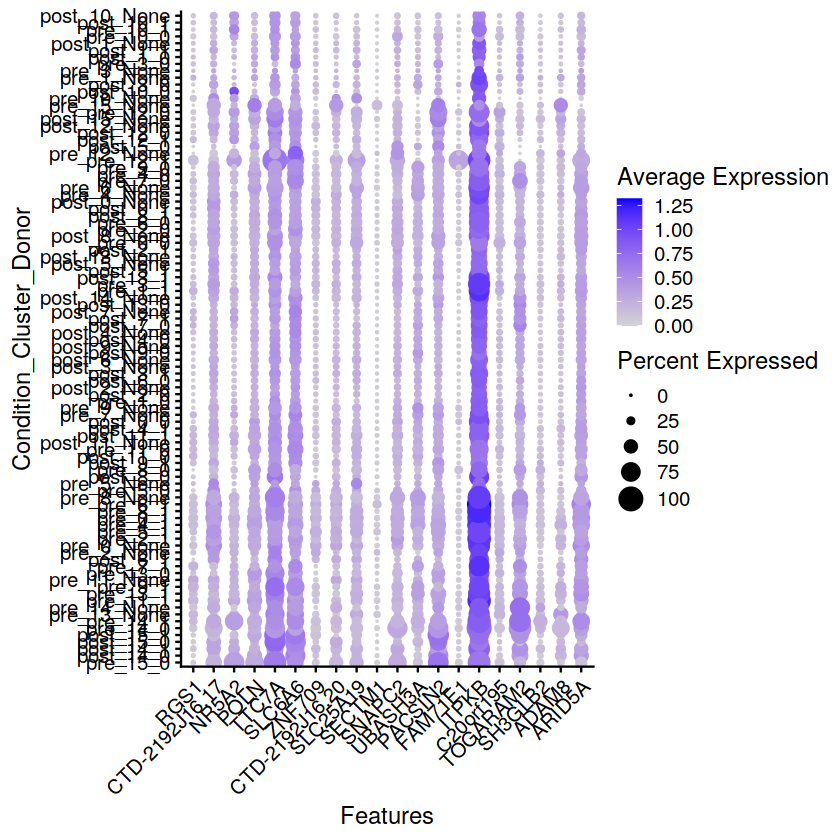

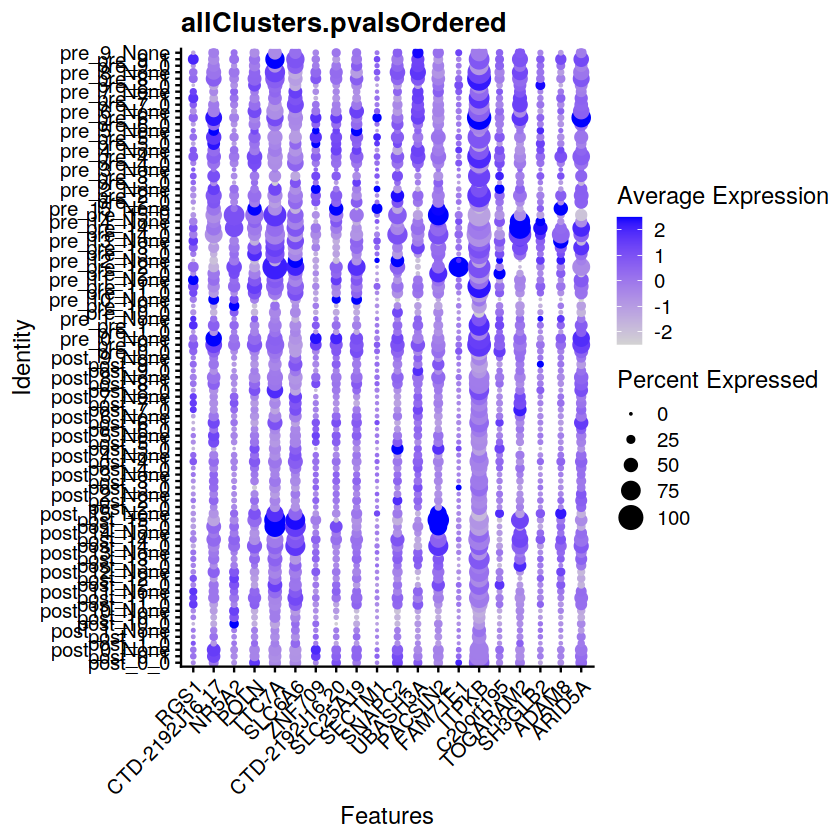

In [11]:
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=FALSE,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis() + ylab("Condition_Cluster_Donor")
dot

de.plots(se, names(sig.all.ordered), btwnConds_inClust_sepDonrs.outdir, 
         curr.name="allClusters.pvalsOrdered", max.size=20)

### Same features, but dont separate by donors

Saving 6.67 x 6.67 in image



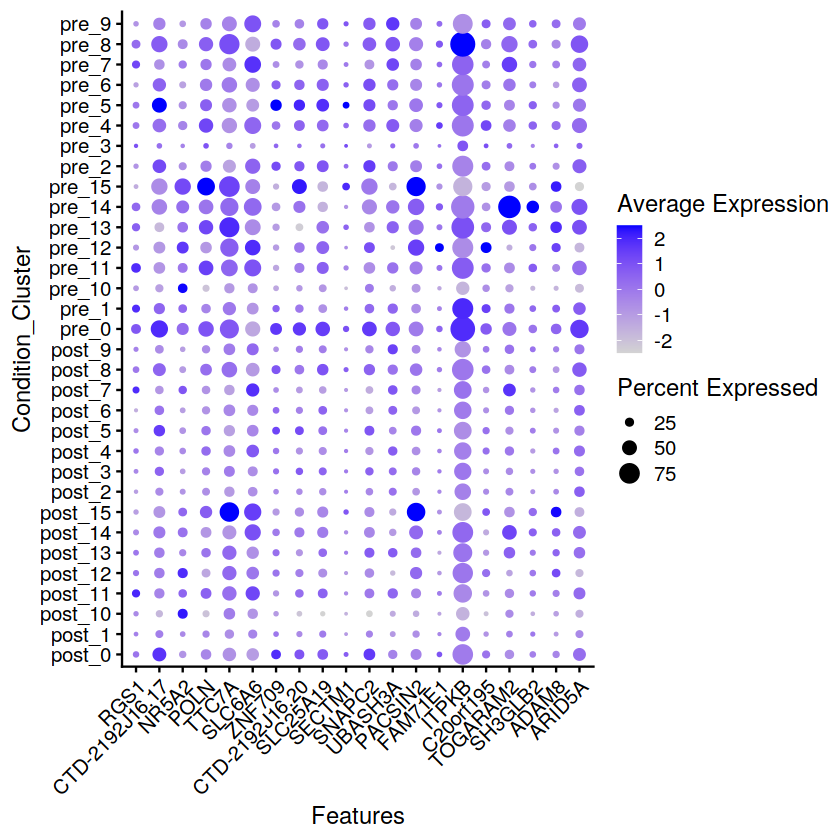

In [12]:
Idents(se)<-se$condition.clust
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Condition_Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.pvalsOrdered.png"))
dot

### Same features, but dont separate by donors or conditions

Saving 6.67 x 6.67 in image



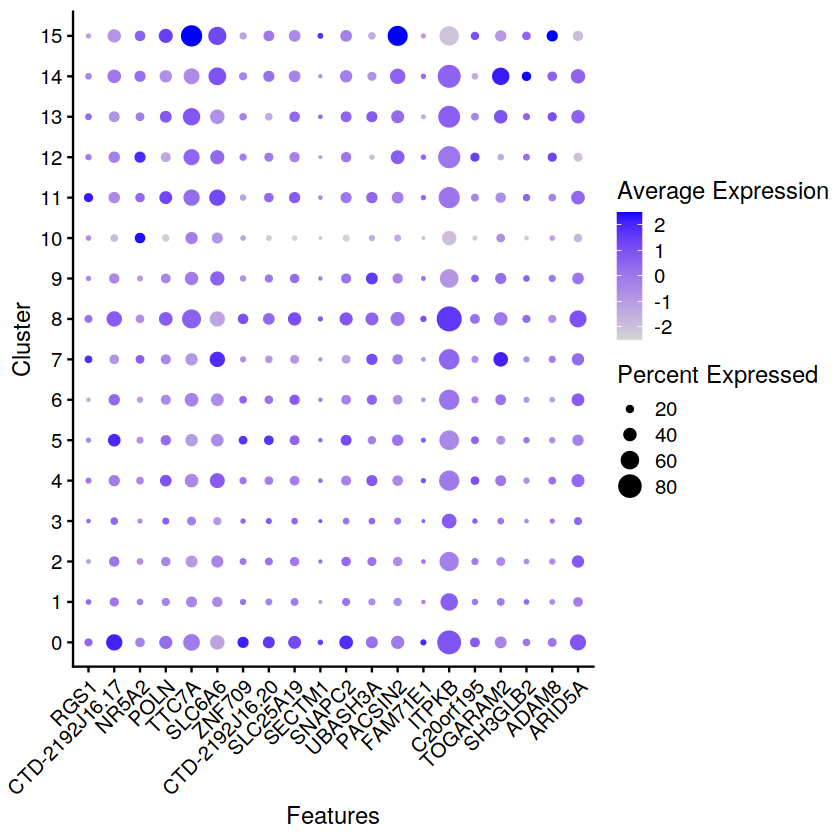

In [13]:
Idents(se)<-se$seurat_clusters
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonorsConds.pvalsOrdered.png"))

dot

## ii. p-values ordered by average -log p-value if they were significant (p<0.1 here), set to 1 otherwise if not sig

Saving 6.67 x 6.67 in image



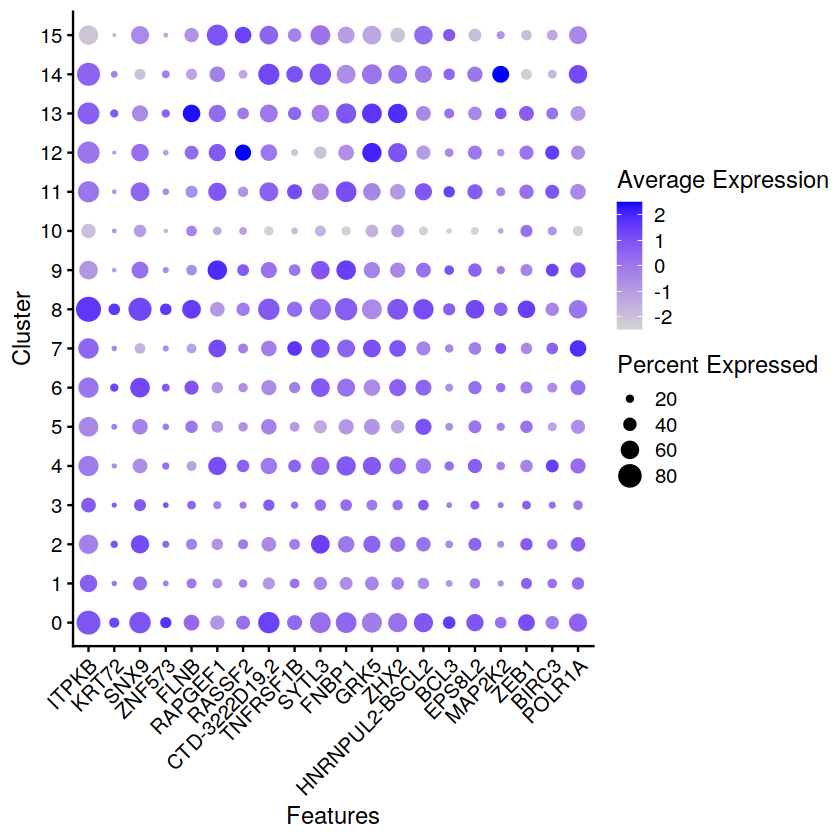

In [14]:
all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

Idents(se)<-se$seurat_clusters
sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonorsConds.pvalsOrderedNA.png"))

dot

Saving 6.67 x 6.67 in image



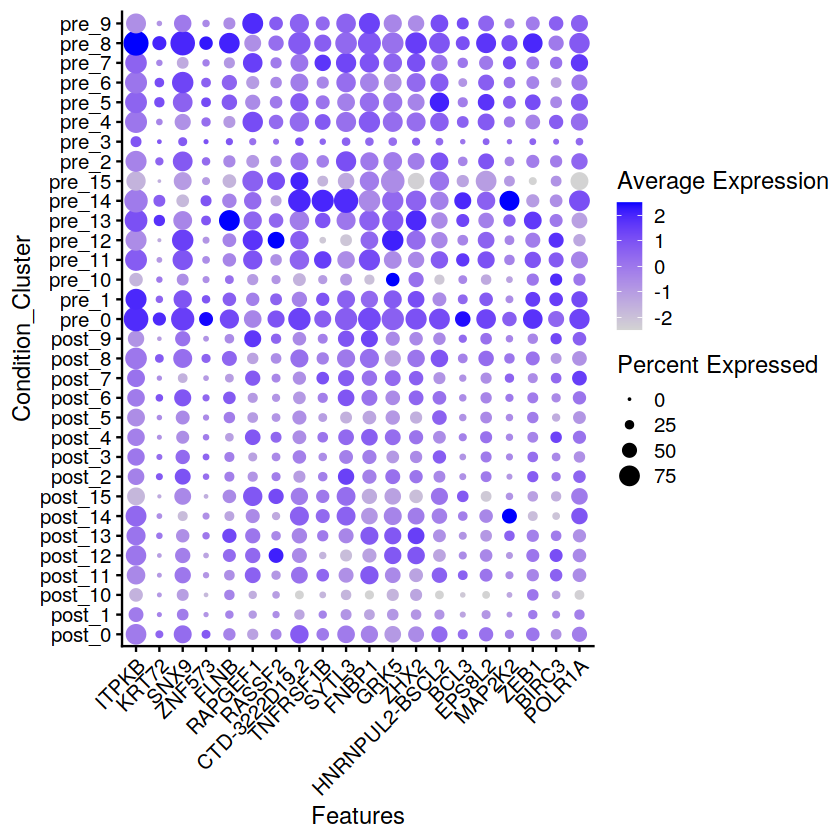

In [15]:
all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

Idents(se)<-se$condition.clust
sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Condition_Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonors.pvalsOrderedNA.png"))

dot

## iii. Taking top 3 of each sig DE

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



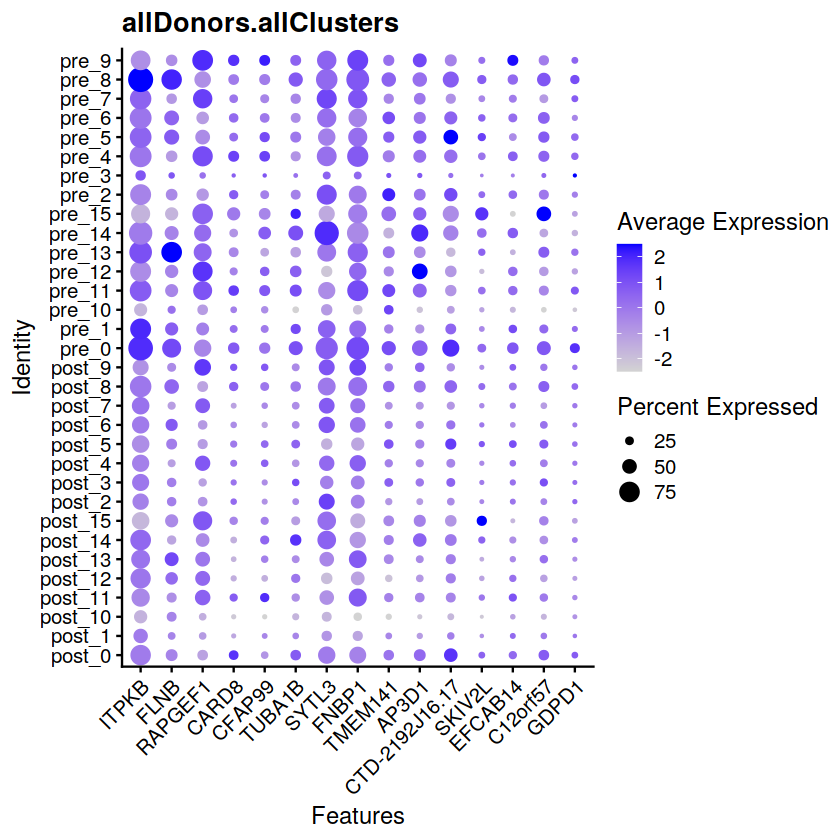

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



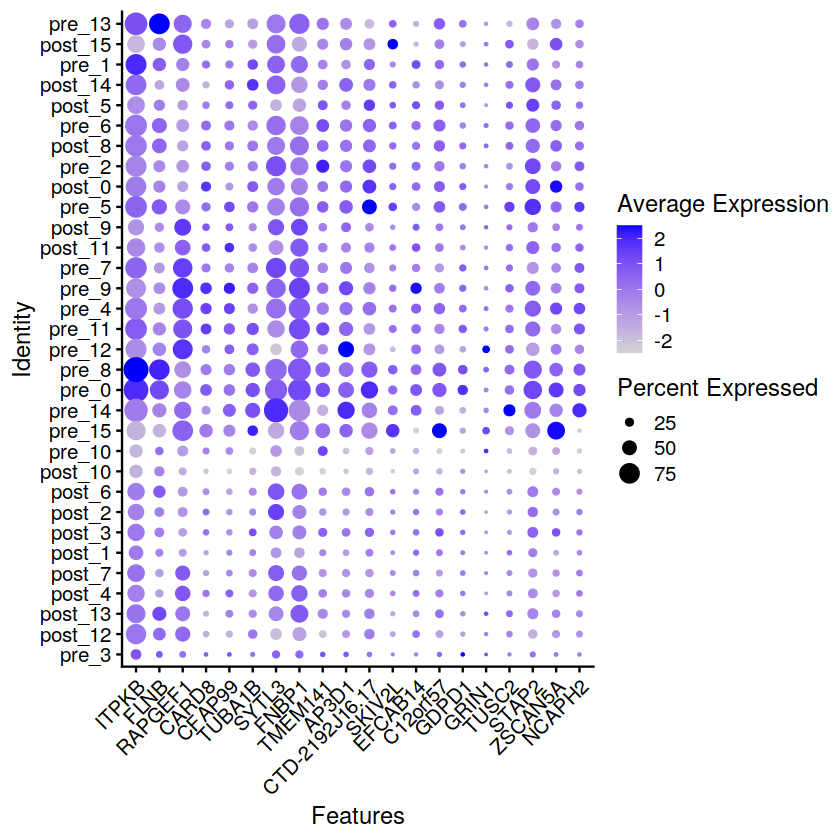

In [16]:
all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, btwnConds_inClust.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=T,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.top3de.png"))
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.top3de.pdf"))

### a) For each cluster, get the top DEs by average across donors and plot by donor and condition
### b) Across all clusters, get the DE counts for each feature and cluster (sum over donors)
### b2) plot heatmap for features by clusters with the counts

In [17]:
# get clust and donor information
clust.ids <- levels(se$seurat_clusters)
don.ids <- levels(se$donor)
#cols <- c("seurat_clusters", "donor")
curr.ids <- levels(as.factor(apply(se[[]][ , c( "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" )))
# Setup Idents to include the condition, clusters and donor
Idents(se) <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
se$curr.id = Idents(se)

# setup output
# all.pvals is gene-by-comparison df of the pvalue results
all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
counts.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),row.names=row.names(se))
all.names.sig <- c()

# Loop through clusters and donors and compare between conditions
for (cl in clust.ids){
    print("cluster")
    print(cl)
    counts.pvals[ ,cl] = 0
    if (cl == "None"){
        next
    }
    
    clust.names.sig <- c()
    clust.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                              row.names=row.names(se))
    for (don in don.ids){
        if (don == "None"){
            print('Skipping None')
            next
        }
        c <- paste0(cl, "_", don)
        cl.names.sig = c()
        
        print("c")
        print(c)
        id1 <- paste(sample_names[[1]], c, sep="_")
        id2 <- paste(sample_names[[2]], c, sep="_")         
        curr.name <- c
        curr.name <- paste(c, sample_names[[1]], sample_names[[2]], sep='_')
        curr.clust.donor.outdir <- file.path(btwnConds_inClust_sepDonrs.outdir,
                                             paste0("clust_", cl, "donor_", don))
        de_f <- file.path(curr.clust.donor.outdir, paste(curr.name,"DE.csv",sep="_"))
        try({
            de <- read.table(de_f, row.names=1, sep=",", header=T )
            print(head(de))
            curr.sig <- de %>% dplyr::filter(p_val_adj_BH<p_thresh)
            if (length(names(curr.sig)) > 0){
                print("adding sig vals to all pvals")
                names.sig <- rownames(curr.sig)
                all.names.sig <- c(all.names.sig, head(names.sig, top_de))
                all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH

                clust.names.sig <- c(clust.names.sig, head(names.sig, top_de))
                clust.pvals[names.sig, don] <- curr.sig$p_val_adj_BH
                counts.pvals[names.sig, cl] = counts.pvals[names.sig, cl] +1 
            }
        })
    }
    try({
    if (cl != "None"){
        clust.outdir <- file.path(btwnConds_inClust_sepDonrs.outdir, paste0("clust_combineDonors", cl))
        dir.create(clust.outdir)
        se.filt <- subset(se, subset = seurat_clusters == cl & donor != "None")
        wrap.plot.over.all(se.filt, clust.outdir, clust.pvals, clust.names.sig, 
                           name=paste0("cluster",cl,"topDonorDE.split_donors"))
    }
        })
}

[1] "cluster"
[1] "0"
[1] "c"
[1] "0_0"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
ASTE1  3.762515e-05  0.3276027 0.354 0.021 0.7365123    0.1454432
DPM2   2.456766e-04  0.2310404 0.250 0.000 1.0000000    0.1454432
AP1S2  2.640746e-04  0.4634705 0.479 0.125 1.0000000    0.1454432
RRP1   2.905585e-04  0.2364869 0.292 0.021 1.0000000    0.1454432
PDXDC1 2.992395e-04  0.4449098 0.688 0.292 1.0000000    0.1454432
COPS7B 3.476340e-04  0.2878775 0.521 0.146 1.0000000    0.1454432
[1] "adding sig vals to all pvals"
[1] "c"
[1] "0_1"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB   4.273353e-41  0.3961630 0.944 0.755 8.365089e-37 1.517040e-38
FLNB    3.072906e-30  0.2478429 0.703 0.372 6.015214e-26 5.454409e-28
RAPGEF1 2.237401e-27  0.2429896 0.631 0.336 4.379713e-23 2.647591e-25
BATF    2.125848e-26  0.1693690 0.360 0.133 4.161348e-22 1.886690e-24
KRT72   3.958617e-26  0.1676726 0.432 0.177 7.748994e-22 2.810618e-24
ZC3H12A 3.696246e-25  0.1

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors0' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "1"
[1] "c"
[1] "1_0"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
CARD8   1.392757e-07  0.3249964 0.299 0.047 0.002726322 0.0003122194
CFAP99  1.552558e-07  0.2585382 0.269 0.035 0.003039132 0.0003122194
TUBA1B  1.202942e-06  0.3682410 0.418 0.117 0.023547599 0.0012873972
CCDC167 1.560320e-06  0.2598332 0.269 0.047 0.030543261 0.0012873972
PBX3    1.703006e-06  0.3892818 0.373 0.099 0.033336339 0.0012873972
NFKBID  2.136804e-06  0.4056546 0.328 0.082 0.041827931 0.0012873972
[1] "adding sig vals to all pvals"
[1] "c"
[1] "1_1"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
SYTL3  3.522934e-26  0.3525230 0.670 0.325 6.896144e-22 3.262237e-23
ITPKB  1.409432e-25  0.4933128 0.810 0.514 2.758964e-21 6.525672e-23
FNBP1  1.295584e-21  0.3478659 0.643 0.328 2.536105e-17 3.999035e-19
RGS1   2.366877e-21  0.2054778 0.233 0.055 4.633162e-17 5.479321e-19
ABCG1  3.763999e-20  0.2963456 0.514 0.241 7.368029e-16 6.970927e-18
TGFBR3 7.3

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors1' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "2"
[1] "c"
[1] "2_0"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TMEM141        6.600979e-22  0.1903946 0.432 0.189 1.292142e-17 2.785613e-19
AP3D1          2.233975e-20  0.1497062 0.366 0.147 4.373006e-16 4.713688e-18
CTD-2192J16.17 3.738663e-20  0.1728178 0.437 0.192 7.318434e-16 5.259053e-18
PLK3           9.795278e-19  0.1249408 0.380 0.161 1.917426e-14 1.033402e-16
RP11-216L13.17 2.941021e-18  0.1778844 0.487 0.238 5.757049e-14 2.482222e-16
CTC-435M10.3   5.737463e-18  0.1887786 0.591 0.315 1.123108e-13 4.035349e-16
[1] "adding sig vals to all pvals"
[1] "c"
[1] "2_1"
                p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
SKIV2L   4.149904e-06  0.2864778 0.458 0.053 0.08123438  0.008917829
EFCAB14  4.955900e-06  0.2697946 0.500 0.070 0.09701173  0.008917829
C12orf57 6.762106e-06  0.3354305 0.562 0.105 0.13236823  0.008917829
NELFE    9.058344e-06  0.2823043 0.438 0.053 0.17731708  0.008917829
DHRS12   1.268967e-05  

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors2' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "3"
[1] "c"
[1] "3_0"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
MEX3C   8.774148e-05 -0.8045195 0.086 0.533         1    0.4605834
ELMO2   2.487335e-04  0.7079821 0.371 0.000         1    0.4605834
PRKACA  5.989686e-04 -0.6153752 0.029 0.367         1    0.4605834
CBR4    9.200944e-04  0.6014521 0.314 0.000         1    0.4605834
FAM163A 1.297436e-03 -0.4668021 0.000 0.267         1    0.4605834
NUP205  1.297436e-03 -0.5039542 0.000 0.267         1    0.4605834
[1] "adding sig vals to all pvals"
[1] "c"
[1] "3_1"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
GDPD1   1.679450e-07  0.3398209 0.311 0.089 0.003287524 0.0004835137
GRIN1   5.998061e-07  0.1506516 0.148 0.022 0.011741205 0.0008161973
TUSC2   8.505008e-07  0.2483686 0.311 0.091 0.016648553 0.0008161973
SNX9    8.808533e-06  0.5474059 0.803 0.533 0.172427028 0.0062009815
B4GALT6 1.076933e-05  0.1365111 0.164 0.034 0.210809679 0.0062009815
ZDHHC3  1.360315e-05  0.

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors3' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "4"
[1] "c"
[1] "4_0"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
STAP2   1.562613e-17  0.2160780 0.578 0.266 3.058815e-13 6.193454e-15
ZSCAN5A 2.487331e-17  0.1882239 0.410 0.158 4.868950e-13 6.193454e-15
NCAPH2  3.208428e-16  0.1286988 0.349 0.122 6.280498e-12 5.325991e-14
LMF2    6.635680e-16  0.1222404 0.342 0.119 1.298934e-11 8.235850e-14
ZNF83   8.268926e-16  0.1385630 0.467 0.198 1.618642e-11 8.235850e-14
MIDN    1.863386e-15  0.1726049 0.456 0.198 3.647578e-11 1.546610e-13
[1] "adding sig vals to all pvals"
[1] "c"
[1] "4_1"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
BCL3   3.651329e-10  0.4095417 0.613 0.182 7.147476e-06 6.864498e-07
ZC3H18 3.943567e-08  0.3023038 0.453 0.121 7.719532e-04 3.706953e-05
HMHA1  3.750542e-07  0.3484346 0.764 0.356 7.341687e-03 1.992583e-04
ITPKB  5.388724e-07  0.4883958 0.943 0.727 1.054843e-02 1.992583e-04
BCL11B 5.656327e-07  0.4202542 0.981 0.758 1.107226e-02 1.992583e-04
TGF

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors4' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "5"
[1] "c"
[1] "5_0"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
TGIF2   1.139571e-05 -0.7805533 0.050   0.6 0.2230711   0.09717125
OSTC    4.556232e-04 -0.3293009 0.000   0.3 1.0000000   0.57826602
VWDE    4.556232e-04 -0.4375341 0.000   0.3 1.0000000   0.57826602
SLITRK5 4.556232e-04 -0.5305894 0.000   0.3 1.0000000   0.57826602
TRIM36  6.172514e-04 -0.4236044 0.025   0.4 1.0000000   0.57826602
TM7SF2  8.261615e-04 -0.4912860 0.075   0.5 1.0000000   0.57826602
[1] "adding sig vals to all pvals"
[1] "c"
[1] "5_1"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT72    6.040458e-29  0.2444806 0.373 0.068 1.182420e-24 7.151902e-26
CCDC57   5.801586e-21  0.3746827 0.687 0.278 1.135660e-16 3.434539e-18
SECTM1   9.336136e-17  0.1111170 0.187 0.030 1.827549e-12 3.684662e-14
MAP2K2   1.847825e-16  0.2194522 0.500 0.175 3.617117e-12 5.469562e-14
SYTL3    8.656884e-16  0.3541805 0.717 0.345 1.694585e-11 2.049950e-13
TNFRSF1B 6.6

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors5' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "6"
[1] "c"
[1] "6_0"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
OSBPL2 8.146560e-18  0.1748235 0.323 0.105 1.594689e-13 3.397115e-15
SEPT2  3.861158e-16  0.1601014 0.428 0.168 7.558216e-12 8.050514e-14
AP2A1  9.097888e-16  0.1612778 0.515 0.221 1.780912e-11 1.264606e-13
TCTA   1.747052e-15  0.1627509 0.466 0.197 3.419855e-11 1.821302e-13
IL4I1  3.259690e-15  0.1307354 0.318 0.110 6.380843e-11 2.718581e-13
RFXANK 4.010502e-15  0.1280338 0.273 0.087 7.850558e-11 2.787299e-13
[1] "adding sig vals to all pvals"
[1] "c"
[1] "6_1"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
ABHD8   5.654144e-06  0.5796588 0.774 0.143 0.1106799   0.03284492
MRPL34  3.471722e-05  0.4820218 0.613 0.071 0.6795897   0.06997911
C8orf37 3.614001e-05  0.4443123 0.742 0.143 0.7074407   0.06997911
WIPI1   1.176958e-04  0.4621794 0.548 0.071 1.0000000   0.15671791
PQLC1   1.376902e-04  0.5095042 0.613 0.107 1.0000000   0.15671791
WWC3    1.642386e-04  

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors6' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "7"
[1] "c"
[1] "7_0"
                     p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TCF3          7.358072e-12  0.1696526 0.285 0.075 1.440343e-07 7.372788e-09
CNOT3         1.150767e-10  0.2115735 0.570 0.259 2.252626e-06 4.740139e-08
PAK2          1.419203e-10  0.1227857 0.308 0.095 2.778090e-06 4.740139e-08
CARM1         1.952634e-10  0.1710791 0.437 0.178 3.822280e-06 4.891347e-08
SYNGR4        2.808445e-10  0.1981167 0.371 0.142 5.497532e-06 5.628124e-08
RP5-994D16.12 3.916779e-10  0.1367710 0.325 0.109 7.667094e-06 6.541020e-08
[1] "adding sig vals to all pvals"
[1] "c"
[1] "7_1"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
FBXO16 5.811119e-06  0.3491413 0.679 0.386 0.1137527  0.006870739
ASTL   6.777567e-06  0.3179858 0.268 0.070 0.1326709  0.006870739
PLB1   1.027748e-05  0.3462510 0.500 0.228 0.2011816  0.006870739
SMAP2  1.138718e-05  0.3777624 0.536 0.285 0.2229041  0.006870739
WDR48  1.670514e-05  0.2319208 0.321 0.095 0.

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors7' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "8"
[1] "c"
[1] "8_0"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
CBX7    0.0001038178  0.7047981 0.667 0.167         1    0.3132268
GANAB   0.0001423916  0.3112717 0.476 0.033         1    0.3132268
UBR5    0.0002293523  0.5862501 0.619 0.133         1    0.3132268
DNAJC16 0.0002462983  0.6824770 0.762 0.233         1    0.3132268
PTH2R   0.0004522993  0.4469884 0.667 0.133         1    0.3132268
CIAO1   0.0005682082  0.4943346 0.571 0.100         1    0.3132268
[1] "adding sig vals to all pvals"
[1] "c"
[1] "8_1"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB    2.700011e-34  0.4877636 0.953 0.786 5.285271e-30 1.069204e-31
SNX9     2.573572e-24  0.3548215 0.927 0.650 5.037768e-20 5.095673e-22
TOGARAM2 1.036882e-18  0.1925245 0.564 0.242 2.029696e-14 1.368684e-16
ZC3H18   9.675317e-17  0.1908548 0.427 0.172 1.893943e-12 9.578564e-15
NFATC1   7.651618e-16  0.2684887 0.757 0.444 1.497804e-11 6.060082e-14
POLR1A   4.8

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors8' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "9"
[1] "c"
[1] "9_0"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
FN3KRP         2.116237e-14  0.1179899 0.196 0.035 4.142533e-10 1.250696e-11
MRPS18B        3.421086e-13  0.2113709 0.482 0.202 6.696776e-09 1.010931e-10
C19orf68       1.111128e-12  0.1936371 0.328 0.119 2.175032e-08 2.188921e-10
LIG1           3.000523e-12  0.1758435 0.313 0.112 5.873523e-08 3.741779e-10
TRIM26         3.165634e-12  0.1498625 0.383 0.151 6.196728e-08 3.741779e-10
HNRNPUL2-BSCL2 9.469821e-12  0.2559065 0.651 0.369 1.853718e-07 9.327774e-10
[1] "adding sig vals to all pvals"
[1] "c"
[1] "9_1"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
PLCD3   3.898696e-05  0.2620386 0.267 0.000 0.7631697   0.05745492
SPRYD3  4.602550e-05  0.2994078 0.467 0.088 0.9009491   0.05745492
IL12RB2 6.179049e-05  0.3420296 0.378 0.053 1.0000000   0.05745492
BTBD11  7.310323e-05  0.5898465 0.800 0.404 1.0000000   0.05745492
EGR3    7.962325e-05  0.2935438 0

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors9' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "10"
[1] "c"
[1] "10_0"
                p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
CCDC102B 0.0000495871  0.9413636 0.667 0.115 0.9706676     0.337276
CUBN     0.0001532291  0.9516263 0.606 0.115 1.0000000     0.337276
GRIN3A   0.0002475280  0.6376084 0.576 0.077 1.0000000     0.337276
MAP3K2   0.0005634473  0.4660209 0.545 0.077 1.0000000     0.337276
PKP4     0.0006241028  0.5848615 0.636 0.154 1.0000000     0.337276
CTTNBP2  0.0007357327  0.4594436 0.364 0.000 1.0000000     0.337276
[1] "adding sig vals to all pvals"
[1] "c"
[1] "10_1"
                   p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
TMEM208     2.929361e-10  0.3873045 0.273 0.023 5.734224e-06 1.939237e-06
FKBPL       6.764897e-09  0.2506532 0.227 0.018 1.324229e-04 2.239181e-05
AC040160.13 1.513390e-08  0.3802543 0.273 0.029 2.962461e-04 3.339547e-05
UBE4A       8.520765e-08  0.4514887 0.364 0.059 1.667940e-03 1.410187e-04
SCAMP3      1.578425e-07  0.2276812 0.227 0.023 3.089768e-

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors10' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "11"
[1] "c"
[1] "11_0"
               p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
MANF    6.411992e-07  0.2714581 0.351 0.062 0.01255147  0.001645317
DPAGT1  2.525167e-06  0.2685041 0.430 0.124 0.04943014  0.003239789
C2CD2L  6.728337e-06  0.2554585 0.456 0.155 0.13170719  0.005754971
DAP3    2.067225e-05  0.1983254 0.263 0.041 0.40465920  0.012050985
SLC26A2 2.348204e-05  0.2513293 0.439 0.155 0.45966100  0.012050985
YY1AP1  3.571076e-05  0.1773342 0.254 0.041 0.69903815  0.014426612
[1] "adding sig vals to all pvals"
[1] "c"
[1] "11_1"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
ITPKB  2.573866e-06  0.4927483 0.923 0.780 0.05038343  0.005110270
BCL11B 4.116206e-06  0.5271817 0.904 0.703 0.08057473  0.005110270
SNX9   6.359097e-06  0.3900272 0.865 0.626 0.12447932  0.005263212
FAM76B 2.118400e-05  0.3686039 0.808 0.484 0.41467683  0.009153413
SCD5   2.165724e-05 -0.1900655 0.019 0.209 0.42394043  0.009153413
RSPO2  2.211860e-05 -0.233

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors11' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "12"
[1] "c"
[1] "12_0"
                    p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
FAM65A       1.182830e-07  0.5823152 0.717 0.200 0.002315389 0.0004697016
ZSCAN31      1.189727e-05  0.3240867 0.435 0.067 0.232888978 0.0236220213
RP11-463C8.4 2.055534e-05  0.4883690 0.696 0.233 0.402370817 0.0272084208
ZNF200       6.113081e-05  0.2187390 0.283 0.017 1.000000000 0.0606876135
U2SURP       1.010641e-04  0.3797345 0.413 0.083 1.000000000 0.0702325498
AK7          1.061182e-04  0.4124500 0.630 0.233 1.000000000 0.0702325498
[1] "adding sig vals to all pvals"
[1] "c"
[1] "12_1"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
FAM71E1 9.131525e-17  0.4731927 0.778  0.01 1.787496e-12 3.162247e-13
EMC10   9.131525e-17  0.4731927 0.778  0.01 1.787496e-12 3.162247e-13
RPP21   1.265201e-12  0.4108409 0.667  0.02 2.476631e-08 2.920927e-09
ZNF549  1.553007e-11  0.3516227 0.444  0.00 3.040012e-07 2.689032e-08
BRAT1   6.392055e-11  0.3871735 0.77

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors12' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "13"
[1] "c"
[1] "13_0"
                 p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
NLK       1.147024e-05  0.5482010 0.667 0.163 0.2245299   0.02952219
ARV1      1.506254e-05  0.6145585 0.576 0.122 0.2948491   0.02952219
THAP7     1.755184e-05  0.2901512 0.333 0.000 0.3435772   0.02952219
TPST2     3.700540e-05  0.4087766 0.455 0.061 0.7243808   0.03997702
TSSC1     4.226572e-05  0.3910491 0.606 0.122 0.8273515   0.03997702
KRTAP10-4 4.753511e-05  0.3236764 0.303 0.000 0.9304997   0.03997702
[1] "adding sig vals to all pvals"
[1] "c"
[1] "13_1"
                    p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
HIPK2        3.836415e-06  0.5417415 0.770 0.325 0.07509782  0.009612297
SLC9A8       5.781833e-06  0.3185675 0.492 0.117 0.11317938  0.009612297
POGZ         1.562669e-05  0.2015720 0.328 0.039 0.30589238  0.011835579
PLEKHG5      1.822918e-05  0.2518433 0.311 0.039 0.35683618  0.011835579
RP5-900K19.2 1.977966e-05  0.3735157 0.689 0.273 0.38718

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors13' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "14"
[1] "c"
[1] "14_0"
             p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
SNU13 0.0000662028  0.4599850 0.889 0.000         1    0.3293299
ITGB2 0.0001796875  0.5974712 0.889 0.077         1    0.3293299
VAX2  0.0002790738  0.3614155 0.778 0.000         1    0.3293299
DHX8  0.0005683064  0.3713840 0.889 0.077         1    0.3293299
PUF60 0.0006144815  0.6011835 1.000 0.154         1    0.3293299
LAP3  0.0006962820  0.5490606 0.889 0.154         1    0.3293299
[1] "adding sig vals to all pvals"
[1] "c"
[1] "14_1"
               p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
CMIP    4.054566e-06  0.8366926 0.962 0.608 0.07936812   0.01824555
ANKRD60 9.823974e-06  0.2324074 0.346 0.000 0.19230429   0.02210394
TRERF1  3.225780e-05  0.5645000 0.808 0.353 0.63144645   0.04838670
RCAN3   5.133243e-05  0.2564349 0.538 0.098 1.00000000   0.05614181
RRM2B   6.237979e-05  0.4808620 0.769 0.314 1.00000000   0.05614181
TNFSF14 9.485365e-05  0.4043449 0.615 0.1

Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors14' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster"
[1] "15"
[1] "c"
[1] "15_0"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
NDE1   4.254935e-06  0.5523583   1.0 0.095 0.08329035   0.02772515
ANPEP  2.526796e-05  0.3048239   0.7 0.000 0.49462030   0.04114703
PLXDC1 2.526796e-05  0.3371082   0.7 0.000 0.49462030   0.04114703
MRPL40 2.526796e-05  0.3485756   0.7 0.000 0.49462030   0.04114703
FANCA  3.518221e-05  0.4751452   0.8 0.048 0.68869170   0.04114703
ACOX1  4.420338e-05  0.3791554   0.8 0.048 0.86528117   0.04114703
[1] "adding sig vals to all pvals"
[1] "c"
[1] "15_1"


Warning message in file(file, "rt"):
"cannot open file '/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_15donor_1/15_1_pre_post_DE.csv': No such file or directory"


Error in file(file, "rt") : cannot open the connection
[1] "Skipping None"


Warning message in dir.create(clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/btwnConds_inClust_sepDonrs/clust_combineDonors15' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [18]:
counts.pvals <- counts.pvals[(!rowSums(counts.pvals) == 0), ]

write.csv(counts.pvals,file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.sharedDE.csv"))


In [19]:
counts.pvals <- na.omit(counts.pvals)

In [20]:
library(circlize)
col_fun = colorRamp2(c(0, max(counts.pvals)), c("white", "blue"))
col_fun(seq(0 , max(counts.pvals)))

pdf(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.sharedDE.png"))

heat <- ComplexHeatmap::Heatmap(head(counts.pvals,15),
        show_column_names = T, use_raster=TRUE, col=col_fun
       )
ComplexHeatmap::draw(heat)
dev.off()


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




[1] "#FFFFFFFF" "#B38BFFFF" "#0000FFFF"

Warning message:
"The input is a data frame, convert it to a matrix."


png 
  2

In [21]:
# Get commone DE values
# tfs_nclust_set_de_overlap = c() # for each tf count number of clusters seen with de results in at least 1 donor
# tfs_clust_de = c()

# clust_dirs = glob.glob(cond_indir+"/clust_*")
# clusters = [basename(x).split("_")[-1] for x in clust_dirs]
# #clusters.sort()

# for i in clust_dirs:
#     print("clusert", i)
#     clust = basename(i).split("_")[-1]
    
#     for d in range(n_donors):
#         print("donor", d)
#         curr_dir = join(i, f"donor{d}")
#         curr_f = glob.glob(join(curr_dir, "*DE.csv"))
#         assert(len(curr_f)<=1)
#         if len(curr_f) == 0:
#             print("no file")
#             continue
#         curr_f = curr_f[0]
#         curr_de = pd.read_csv(curr_f,index_col=0)
#         #print('curr_de', curr_de.shape)
#         curr_de = curr_de.loc[curr_de["p_val_adj_BH"] < p_thresh]
#         for tf in curr_de.index:
#             if tf in tfs_nclust_set_de_overlap.keys():
#                 tfs_nclust_set_de_overlap[tf].add(clust)
#                     #tfs_nclust_de_overlap[tf] += 1
#                 tfs_clust_de[tf].append((clust, d))
#             else:
#                 #tfs_nclust_de_overlap[tf] = 1
#                 tfs_nclust_set_de_overlap[tf] = set([clust])
#                 tfs_clust_de[tf] = [(clust,d)]
#         print('curr_de sig', curr_de.shape)

# tfs_nclust_de_overlap = {k:len(v) for k, v in tfs_nclust_set_de_overlap.items()}
# tfs_nclust_de_overlap = pd.Series(tfs_nclust_de_overlap).sort_values()[::-1]
# cluster_tf = pd.DataFrame(index=tfs_clust_de.keys(), columns = clusters)
# cluster_tf.loc[:,:] = 0


# for tf in tfs_clust_de:
#     for d_cl in tfs_clust_de[tf]:
#         cluster_tf.loc[tf, d_cl[0]] += 1
# cluster_tf

# cluster_tf = cluster_tf.loc[cluster_tf.sum(axis=1).sort_values()[::-1].index,
#                             cluster_tf.sum(axis=0).sort_values()[::-1].index ]
# cluster_tf
#g = sns.clustermap(cluster_tf.astype(int))

--------

--------

In [22]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] circlize_0.4.13           future_1.23.0            
 [3] RColorBrewer_1.1-2        metap_1.1                
 [5] cowplot_1.1.1             magrittr_2.0.1           
 [7] data.table_1.14.2         patchwork_1.1.1          
 [9] ggplot2_3.3.5             EnsDb.Hsapiens.v75_2.99.0
[11] 

In [23]:
outdir

[1] "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones"